# Project: Wrangling and Analyze Data <a class="anchor" id="sixth-bullet"></a>

### Table of Contents

* [Introduction](#first-bullet)
* [Data Gathering](#second-bullet)
* [Assessing Data](#third-bullet)
* [Cleaning Data](#forth-bullet)
* [Analyzing and Visualizing Data](#fifth-bullet)

## Introduction <a class="anchor" id="first-bullet"></a>
This wrangling effort aims to gather information about the WeRateDogs Twitter account, analyze
the data, and see what insights can be gleaned from it.

### Data Gathering <a class="anchor" id="second-bullet"></a>
The data is derived from three separate files. 
1. comma-separated values called twitter_archive_enhanced.csv
    * provided by Udacity and manually downloaded from the Udacity site
2. a tab-separated file named image_predictions.tsv
    * downloaded programmatically using the Requests library from [here](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv)
3. a JSON file tweet_json.txt
    * gathered by querying Twitter’s API to download the JSON data using Python’s Tweepy library



Let's start by importing the necessary libraries

In [3]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import requests
import tweepy
import json
from timeit import default_timer as timer
from tweepy import OAuthHandler

#### Read in the data directly downloaded from WeRateDogs Twitter archive data and assign it to the weratedogs_df dataframe. 

In [5]:
weratedogs_df = pd.read_csv('twitter-archive-enhanced.csv')
weratedogs_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Explore the archived twitter information to get a feel for what data is included

In [3]:
weratedogs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [4]:
weratedogs_df.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [5]:
weratedogs_df.tweet_id.duplicated().sum()

0

In [6]:
weratedogs_df.rating_denominator.value_counts().sort_index()

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

In [7]:
weratedogs_df.rating_numerator.value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

#### Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [8]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
file = open('image_predictions.tsv', 'w')
file.write(r.text)
file.close()


#### Read image_predictions into prediction_df dataframe

In [9]:
prediction_df = pd.read_csv('image_predictions.tsv', delim_whitespace = True)
prediction_df.head()
                        

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Explore the data contained  in the prediction_df dataframe

In [10]:
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


##### Check for duplicates

In [11]:
prediction_df.tweet_id.duplicated().sum()

0

In [12]:
prediction_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [13]:
prediction_df.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
pillow                  1
carousel                1
bald_eagle              1
lorikeet                1
orange                  1
Name: p1, Length: 378, dtype: int64

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [790]:
# Contains error because the cell was accidently run after keys and tokens were removed
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)


tweet_ids = twitter_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepyException as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

AttributeError: 'DataFrame' object has no attribute 'tweet_id'

#### Read the tweet_json file into twitter_df dataframe

In [14]:
twitter_df = pd.read_json('tweet_json.txt', lines=True)
twitter_df


,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,33819,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,25461,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,42908,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,41048,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2015-11-16 00:24:50+00:00,666049248165822465,666049248165822464,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,111,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2350,2015-11-16 00:04:52+00:00,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,311,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2351,2015-11-15 23:21:54+00:00,666033412701032449,666033412701032448,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,128,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2352,2015-11-15 23:05:30+00:00,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,132,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


In [15]:
# Check for duplicated tweet ids
twitter_df.id.duplicated().sum()

0

In [16]:
# Check to see if there are retweets
twitter_df['retweeted_status'].isnull().value_counts()

True     2175
False     179
Name: retweeted_status, dtype: int64

In [17]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

## Assessing Data <a class="anchor" id="third-bullet"></a>


### Quality issues
- Timestamp column in weratedogs_df not datetime data type  
- Unneeded columns in weratedogs_df
- Incorrect denominator in weratedogs_df
- Id column name in twitter_df is not consistent with the other tables
- Incorrect datatype for twitter_id in all dataframes 
- Retweets are not necessary
- Dogs without names or with the name 'a' in weratedogs dataframe
- The breed of dog in the prediction dataframe use a combination of upper and lower case
- Change the stages data type to catagorical 
- Tweets with multiple dogs or dog stages 

### Tidiness issues
1. Three variables in one column in weratedogs dataframe (doggo, fluffer, pupper, puppo)

2. Combine dataframes to eliminate duplicate informtation

## Cleaning Data <a class="anchor" id="forth-bullet"></a>
In this section, all of the quality and tidiness issues are addressed

In [18]:
# Make copies of original pieces of data
weratedogs_clean = weratedogs_df.copy()
predictions_clean = prediction_df.copy()
twitter_clean = twitter_df.copy()


### Issue #1: 

#### Define:
- Change the data type of the timestamp column in weratedogs to datetime data type
- Drop columns that are not needed

#### Code

In [19]:
weratedogs_clean.timestamp = pd.to_datetime(weratedogs_clean.timestamp)
labels = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_user_id', 'source', 
          'retweeted_status_timestamp', 'retweeted_status_id' ]
weratedogs_clean.drop(labels, axis = 1, inplace = True)

#### Test

In [20]:
# Check the columns have been dropped and dytpe for timestamp is datetime
weratedogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   int64              
 1   timestamp           2356 non-null   datetime64[ns, UTC]
 2   text                2356 non-null   object             
 3   expanded_urls       2297 non-null   object             
 4   rating_numerator    2356 non-null   int64              
 5   rating_denominator  2356 non-null   int64              
 6   name                2356 non-null   object             
 7   doggo               2356 non-null   object             
 8   floofer             2356 non-null   object             
 9   pupper              2356 non-null   object             
 10  puppo               2356 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3), object(7)
memory usage: 202.6+ KB


### Issue #2:

#### Define
- Check incorrect denominators
- Remove rows with denominaore not equal to ten because those rows also have multipule dogs or are incorrect according to We Rate Dogs twitter page that states the dogs are some number out of ten.

#### Code

In [21]:
weratedogs_clean.rating_denominator.value_counts()


10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [22]:
# keep only the denominators that are equal to 10
weratedogs_clean = weratedogs_clean[weratedogs_clean['rating_denominator'] == 10]


#### Test

In [23]:
weratedogs_clean.rating_denominator.value_counts()

10    2333
Name: rating_denominator, dtype: int64

### Issue #3:


#### Define
- Rename id column in twitter_clean dataframe to tweet_id for consistancy with the other dataframes
- Change the tweet_id in all dataframes from int64 to string

#### Code

In [24]:
twitter_clean.rename(columns = {'id': 'tweet_id'}, inplace = True)

In [25]:
twitter_clean.tweet_id = twitter_clean.tweet_id.astype('str')
predictions_clean.tweet_id = predictions_clean.tweet_id.astype('str')
weratedogs_clean.tweet_id = weratedogs_clean.tweet_id.astype('str')

#### Test

In [26]:
twitter_clean.tweet_id.dtype

dtype('O')

In [27]:
predictions_clean.tweet_id.dtype

dtype('O')

In [28]:
weratedogs_clean.tweet_id.dtype

dtype('O')

### Issue #4:

#### Define  
  
- Get rid of retweets by removing any non null rows in the retweeted_status column of twitter_clean

#### Code

In [29]:
twitter_clean['retweeted_status'].notnull().value_counts()

False    2175
True      179
Name: retweeted_status, dtype: int64

In [30]:
twitter_clean = twitter_clean[twitter_clean['retweeted_status'].isnull()] 

#### Test

In [31]:
# Only null values left meaning all retweets are gone
twitter_clean['retweeted_status'].isnull().value_counts()

True    2175
Name: retweeted_status, dtype: int64

### Issue #5

#### Define  
  
- Use regex to find the correct dog names from the information pulled down with the Twitter api and use them in the master database

#### Code

In [32]:
# dog_name searches the full_text from twitter_clean, extracts the dog name and adds extracted value to dog_name column
def dog_name(text):
    match = re.search("(Say hello to |This is |Meet |This is.*named |Here is )([A-Z]\w+)", text)
    if match:
        return match.group(2)
    else:
        return None
    
twitter_clean['dog_name'] = twitter_clean.full_text.apply(dog_name)

#### Test

In [33]:
weratedogs_clean.name.value_counts()


None          728
a              54
Charlie        12
Cooper         11
Oliver         11
             ... 
Gert            1
Dex             1
Ace             1
Tayzie          1
Christoper      1
Name: name, Length: 954, dtype: int64

In [34]:
twitter_clean.dog_name.isnull().sum()

765

In [35]:
twitter_clean.dog_name.value_counts()

Charlie       11
Lucy          11
Oliver        10
Cooper        10
Tucker         9
              ..
Geno           1
Stark          1
Beya           1
Kayla          1
Christoper     1
Name: dog_name, Length: 946, dtype: int64

There are 10 less names in the twitter_clean dog_name column. However, 745 dogs were did not really have a name as it was set to none and 55 were indentified as having the name 'a'. It seems the extracted names are more accurate, but to do one more test a random sample will be taken and the full text checked to see if the name is correct.

In [48]:
wrd_names = weratedogs_clean[['tweet_id', 'name']].copy()
twit_names = twitter_clean[['tweet_id', 'dog_name', 'full_text']].copy()
name_accuracy_df = pd.merge(wrd_names, twit_names, on='tweet_id')
name_accuracy_df[name_accuracy_df['name']=='a'][20:30]

,tweet_id,name,dog_name,full_text
1723,674082852460433408,a,None,This is a Sagitariot Baklava mix. Loves her ne...
1741,673715861853720576,a,None,This is a heavily opinionated dog. Loves walls...
1755,673636718965334016,a,Kip,This is a Lofted Aphrodisiac Terrier named Kip...
1794,672604026190569472,a,None,This is a baby Rand Paul. Curls for days. 11/1...
1834,671743150407421952,a,Jacob,This is a Tuscaloosa Alcatraz named Jacob (Yac...
1866,671147085991960577,a,Rufus,This is a Helvetica Listerine named Rufus. Thi...
1916,670427002554466305,a,Spork,This is a Deciduous Trimester mix named Spork....
1925,670361874861563904,a,Cherokee,This is a Rich Mahogany Seltzer named Cherokee...
1928,670303360680108032,a,Hemry,This is a Speckled Cauliflower Yosemite named ...
1946,669923323644657664,a,Alphred,This is a spotted Lipitor Rumpelstiltskin name...


In [49]:
# Clearly the dog's name is not 'a', but is found further in the text. The dog name column is more accurate, 

name_accuracy_df.iloc[1755].full_text

'This is a Lofted Aphrodisiac Terrier named Kip. Big fan of bed n breakfasts. Fits perfectly. 10/10 would pet firmly https://t.co/gKlLpNzIl3'

In [50]:
# Again the dog's name is not 'a' and is not included in the tweet
name_accuracy_df.iloc[1834].full_text

'This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7'

### Issue #6  
  
#### Define
- Change the dog breeds to all lowercase using str.lower()
- Remove "-" and replace with a space using str.replace()

#### Code

In [51]:
# Only concerned with the first two predictions because the third will be dropped
predictions_clean['p1'] = predictions_clean.p1.str.lower().str.replace("_", " " )
predictions_clean['p2'] = predictions_clean.p2.str.lower().str.replace("_", " ")

#### Test

In [52]:
predictions_clean.p1.value_counts()

golden retriever      150
labrador retriever    100
pembroke               89
chihuahua              83
pug                    57
                     ... 
pillow                  1
carousel                1
bald eagle              1
lorikeet                1
orange                  1
Name: p1, Length: 378, dtype: int64

In [53]:
predictions_clean.p2.value_counts()

labrador retriever    104
golden retriever       92
cardigan               74
chihuahua              44
pomeranian             42
                     ... 
horse cart              1
tray                    1
pier                    1
red fox                 1
bagel                   1
Name: p2, Length: 404, dtype: int64

### Tidiness #1
  
#### Define
- Create a new column called unknown that will contain the null values for melting the doggo, floofer, pupper, puppo, unknown columns into one column. 

In [54]:
# create a small table with only necessary columns to melt
dog_stage_df  = weratedogs_clean[['tweet_id', 'doggo', 'floofer', 'pupper', 'puppo']].copy()
dog_stage_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2355
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  2333 non-null   object
 1   doggo     2333 non-null   object
 2   floofer   2333 non-null   object
 3   pupper    2333 non-null   object
 4   puppo     2333 non-null   object
dtypes: object(5)
memory usage: 109.4+ KB


In [55]:
# Create a unknown column so when melted there will be a value in the stage column
def unknown(row):
    if row['doggo']=='None' and row['floofer']=='None' and row['pupper']=='None' and row['puppo']=='None':
        value='Unknown'
    else:
        value='None'
    return value

dog_stage_df['unknown'] = dog_stage_df.apply(unknown, axis =1)

In [56]:
dog_stage_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2355
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  2333 non-null   object
 1   doggo     2333 non-null   object
 2   floofer   2333 non-null   object
 3   pupper    2333 non-null   object
 4   puppo     2333 non-null   object
 5   unknown   2333 non-null   object
dtypes: object(6)
memory usage: 127.6+ KB


In [57]:
# Melt columns into one column
ids = ['tweet_id']
values = ['doggo', 'floofer', 'pupper', 'puppo', 'unknown']
dog_stage_df = pd.melt(dog_stage_df, id_vars=ids, value_vars=values, var_name='stage')

In [58]:
dog_stage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11665 entries, 0 to 11664
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  11665 non-null  object
 1   stage     11665 non-null  object
 2   value     11665 non-null  object
dtypes: object(3)
memory usage: 273.5+ KB


In [59]:
# Get rid of the extra value column created by melting 
dog_stage_df = dog_stage_df[dog_stage_df['value'] != 'None']
dog_stage_df = dog_stage_df.drop('value', axis=1)

In [60]:
dog_stage_df.shape

(2347, 2)

#### Test
  

In [67]:
dog_stage_df[dog_stage_df['stage']=='pupper'][:2]

,tweet_id,stage
4695,886366144734445568,pupper
4715,882762694511734784,pupper


In [65]:
# Check the tweet id in weratedogs to make sure the stage in dog_stage_df is correct. 
weratedogs_clean.loc[weratedogs_clean['tweet_id'] == '886366144734445568']

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
29,886366144734445568,2017-07-15 23:25:31+00:00,This is Roscoe. Another pupper fallen victim t...,https://twitter.com/dog_rates/status/886366144...,12,10,Roscoe,None,None,pupper,None


In [66]:
weratedogs_clean.loc[weratedogs_clean['tweet_id'] == '882762694511734784']

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
49,882762694511734784,2017-07-06 00:46:41+00:00,This is Gus. He's quite the cheeky pupper. Alr...,https://twitter.com/dog_rates/status/882762694...,12,10,Gus,None,None,pupper,None


The single column stage in dog_stage_df has produced the same outcome as the separted columns in weratedogs.

In [68]:
weratedogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2333 non-null   object             
 1   timestamp           2333 non-null   datetime64[ns, UTC]
 2   text                2333 non-null   object             
 3   expanded_urls       2278 non-null   object             
 4   rating_numerator    2333 non-null   int64              
 5   rating_denominator  2333 non-null   int64              
 6   name                2333 non-null   object             
 7   doggo               2333 non-null   object             
 8   floofer             2333 non-null   object             
 9   pupper              2333 non-null   object             
 10  puppo               2333 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2), object(8)
memory usage: 218.7+ KB


In [69]:
weratedogs_clean = weratedogs_clean.merge(dog_stage_df, on ='tweet_id')

In [70]:
weratedogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2347 entries, 0 to 2346
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2347 non-null   object             
 1   timestamp           2347 non-null   datetime64[ns, UTC]
 2   text                2347 non-null   object             
 3   expanded_urls       2292 non-null   object             
 4   rating_numerator    2347 non-null   int64              
 5   rating_denominator  2347 non-null   int64              
 6   name                2347 non-null   object             
 7   doggo               2347 non-null   object             
 8   floofer             2347 non-null   object             
 9   pupper              2347 non-null   object             
 10  puppo               2347 non-null   object             
 11  stage               2347 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2

The number of rows has increased because some of the tweet_ids have been duplicated to allow for multiple stages of dogs. We will drop these duplicates in issue #8

### Issue #7  
  
### Define
- Change datatype for stage to catagorical 

In [71]:
weratedogs_clean.stage = weratedogs_clean.stage.astype('category')

### Test

In [72]:
weratedogs_clean.stage.dtype

CategoricalDtype(categories=['doggo', 'floofer', 'pupper', 'puppo', 'unknown'], ordered=False)

### Issue #8   
  
#### Define
- drop duplicated tweet_ids

In [73]:
# Look at duplicate tweets
weratedogs_clean[weratedogs_clean.tweet_id.duplicated(keep=False)]

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage
191,855851453814013952,2017-04-22 18:31:02+00:00,Here's a puppo participating in the #ScienceMa...,https://twitter.com/dog_rates/status/855851453...,13,10,None,doggo,None,None,puppo,doggo
192,855851453814013952,2017-04-22 18:31:02+00:00,Here's a puppo participating in the #ScienceMa...,https://twitter.com/dog_rates/status/855851453...,13,10,None,doggo,None,None,puppo,puppo
201,854010172552949760,2017-04-17 16:34:26+00:00,"At first I thought this was a shy doggo, but i...",https://twitter.com/dog_rates/status/854010172...,11,10,None,doggo,floofer,None,None,doggo
202,854010172552949760,2017-04-17 16:34:26+00:00,"At first I thought this was a shy doggo, but i...",https://twitter.com/dog_rates/status/854010172...,11,10,None,doggo,floofer,None,None,floofer
459,817777686764523521,2017-01-07 16:59:28+00:00,"This is Dido. She's playing the lead role in ""...",https://twitter.com/dog_rates/status/817777686...,13,10,Dido,doggo,None,pupper,None,doggo
460,817777686764523521,2017-01-07 16:59:28+00:00,"This is Dido. She's playing the lead role in ""...",https://twitter.com/dog_rates/status/817777686...,13,10,Dido,doggo,None,pupper,None,pupper
530,808106460588765185,2016-12-12 00:29:28+00:00,Here we have Burke (pupper) and Dexter (doggo)...,https://twitter.com/dog_rates/status/808106460...,12,10,None,doggo,None,pupper,None,doggo
531,808106460588765185,2016-12-12 00:29:28+00:00,Here we have Burke (pupper) and Dexter (doggo)...,https://twitter.com/dog_rates/status/808106460...,12,10,None,doggo,None,pupper,None,pupper
565,802265048156610565,2016-11-25 21:37:47+00:00,"Like doggo, like pupper version 2. Both 11/10 ...",https://twitter.com/dog_rates/status/802265048...,11,10,None,doggo,None,pupper,None,doggo
566,802265048156610565,2016-11-25 21:37:47+00:00,"Like doggo, like pupper version 2. Both 11/10 ...",https://twitter.com/dog_rates/status/802265048...,11,10,None,doggo,None,pupper,None,pupper


In [74]:
weratedogs_clean.drop_duplicates('tweet_id', keep = False, inplace = True)

#### Test

In [75]:
weratedogs_clean[weratedogs_clean.tweet_id.duplicated(keep=False)]

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage


In [76]:
weratedogs_clean.shape

(2319, 12)

In [77]:
labels = ['doggo', 'floofer','pupper', 'puppo' ]
weratedogs_clean.drop(labels, axis = 1, inplace = True)
weratedogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2346
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2319 non-null   object             
 1   timestamp           2319 non-null   datetime64[ns, UTC]
 2   text                2319 non-null   object             
 3   expanded_urls       2264 non-null   object             
 4   rating_numerator    2319 non-null   int64              
 5   rating_denominator  2319 non-null   int64              
 6   name                2319 non-null   object             
 7   stage               2319 non-null   category           
dtypes: category(1), datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 147.4+ KB


### Tidiness  #2
  
#### Define
- Create a master database to purge any duplicated information

In [78]:
master_df = weratedogs_clean.merge(predictions_clean, on ='tweet_id')
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2044 entries, 0 to 2043
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2044 non-null   object             
 1   timestamp           2044 non-null   datetime64[ns, UTC]
 2   text                2044 non-null   object             
 3   expanded_urls       2044 non-null   object             
 4   rating_numerator    2044 non-null   int64              
 5   rating_denominator  2044 non-null   int64              
 6   name                2044 non-null   object             
 7   stage               2044 non-null   category           
 8   jpg_url             2044 non-null   object             
 9   img_num             2044 non-null   int64              
 10  p1                  2044 non-null   object             
 11  p1_conf             2044 non-null   float64            
 12  p1_dog              2044 non-null 

In [79]:
master_df = master_df.merge(twitter_clean, on = 'tweet_id')
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1965 entries, 0 to 1964
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       1965 non-null   object             
 1   timestamp                      1965 non-null   datetime64[ns, UTC]
 2   text                           1965 non-null   object             
 3   expanded_urls                  1965 non-null   object             
 4   rating_numerator               1965 non-null   int64              
 5   rating_denominator             1965 non-null   int64              
 6   name                           1965 non-null   object             
 7   stage                          1965 non-null   category           
 8   jpg_url                        1965 non-null   object             
 9   img_num                        1965 non-null   int64              
 10  p1                      

In [80]:
master_clean  = master_df.copy()

In [81]:
labels = ['quoted_status', 'quoted_status_id_str', 'quoted_status_id', 'retweeted_status', 'lang', 
          'possibly_sensitive_appealable', 'possibly_sensitive', 'is_quote_status', 'contributors', 
          'place', 'coordinates', 'geo', 'in_reply_to_screen_name', 'in_reply_to_user_id_str', 
          'in_reply_to_status_id_str', 'extended_entities', 'entities', 'display_text_range', 
          'truncated', 'p3_dog', 'p3_conf', 'p3', 'in_reply_to_status_id', 'in_reply_to_user_id', 'created_at',
          'full_text', 'user', 'name', 'p2_dog', 'p2_conf', 'p2', 'favorited', 'retweeted', 'id_str', 'source', 
          'img_num', 'expanded_urls']
master_clean.drop(labels, axis = 1, inplace = True)
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1965 entries, 0 to 1964
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1965 non-null   object             
 1   timestamp           1965 non-null   datetime64[ns, UTC]
 2   text                1965 non-null   object             
 3   rating_numerator    1965 non-null   int64              
 4   rating_denominator  1965 non-null   int64              
 5   stage               1965 non-null   category           
 6   jpg_url             1965 non-null   object             
 7   p1                  1965 non-null   object             
 8   p1_conf             1965 non-null   float64            
 9   p1_dog              1965 non-null   bool               
 10  retweet_count       1965 non-null   int64              
 11  favorite_count      1965 non-null   int64              
 12  dog_name            1362 non-null 

In [82]:
# Rename colums for clarity
master_clean.rename(columns = {'p1':'dog_breed', 'p1_conf':'dog_breed_confidence', 'p1_dog':'dog'}, inplace=True)

In [83]:
master_clean.sample(3)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,stage,jpg_url,dog_breed,dog_breed_confidence,dog,retweet_count,favorite_count,dog_name
265,829861396166877184,2017-02-10 01:15:49+00:00,This is Mia. She already knows she's a good do...,12,10,unknown,https://pbs.twimg.com/media/C4RCiIHWYAAwgJM.jpg,border terrier,0.394486,True,2243,13441,Mia
853,727644517743104000,2016-05-03 23:42:26+00:00,Here's a doggo struggling to cope with the win...,13,10,doggo,https://pbs.twimg.com/media/Chkc1BQUoAAa96R.jpg,great pyrenees,0.457164,True,1962,6431,None
1489,675334060156301312,2015-12-11 15:19:21+00:00,Good morning here's a grass pupper. 12/10 http...,12,10,pupper,https://pbs.twimg.com/media/CV9EvZNUwAAgLCK.jpg,pembroke,0.773135,True,1436,3007,None


### Issue #9  
  
#### Define
- Drop high numerator outliers

In [84]:
master_clean.rating_numerator.value_counts()

12      445
10      418
11      394
13      259
9       150
8        95
7        51
14       35
5        32
6        32
3        19
4        15
2         9
1         4
0         2
27        1
75        1
1776      1
26        1
420       1
Name: rating_numerator, dtype: int64

In [85]:
master_clean = master_clean[master_clean['rating_numerator'] < 26]

In [86]:
master_clean.rating_numerator.value_counts()

12    445
10    418
11    394
13    259
9     150
8      95
7      51
14     35
5      32
6      32
3      19
4      15
2       9
1       4
0       2
Name: rating_numerator, dtype: int64

In [87]:
master_clean.shape

(1960, 13)

In [91]:
# Check for duplicate tweet_id
master_clean[master_clean.tweet_id.duplicated()]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,stage,jpg_url,dog_breed,dog_breed_confidence,dog,retweet_count,favorite_count,dog_name


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [213]:
master_clean.to_csv('twitter_archive_master.csv', index = False)

## Analyzing and Visualizing Data <a class="anchor" id="fifth-bullet"></a>


### Insight #1

In [959]:
# The average rating is a little over 10 out of 10. 
master_clean.rating_numerator.describe()

count    1960.000000
mean       10.545408
std         2.185146
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating_numerator, dtype: float64

The average rating is a little over 10. 

In [945]:
# Dog name and retweet
columns = ['dog_name','favorite_count', 'retweet_count']
df_name_retweet = master_clean[columns].dropna()
df_name_retweet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1359 entries, 0 to 1935
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   dog_name        1359 non-null   object
 1   favorite_count  1359 non-null   int64 
 2   retweet_count   1359 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 42.5+ KB


I was interested to see if there was any connection between the dogs name and the number of favorites and retweets that the post recieved. 

    dog_name  retweet_count  favorite_count
100       Bo          73800          185922
808  Stephan          56625          107015
261  Duddles          45849          107956
137    Buddy          39599           77940
542     Lucy          35313          110523


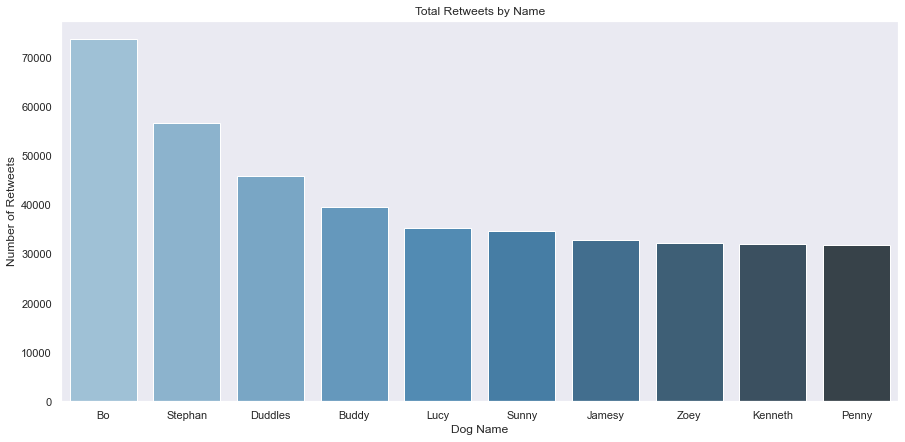

In [94]:
# Which dog name recieved the most retweets
df_name_total = master_clean.groupby('dog_name').agg({'retweet_count': 'sum', 'favorite_count': 'sum'}).reset_index()
print(df_name_total.sort_values(by = 'retweet_count', ascending = False).head())
fig, ax = plt.subplots(figsize = (15,7))
sns.set_theme(style='dark')
ax = sns.barplot(x='dog_name', y='retweet_count', data=df_name_total.sort_values('retweet_count', ascending = False).iloc[:10],palette="Blues_d")
ax.set(xlabel = "Dog Name", ylabel = "Number of Retweets", title = "Total Retweets by Name");

    dog_name  retweet_count  favorite_count
100       Bo          73800          185922
167  Charlie          30850          115468
920     Zoey          32201          113581
542     Lucy          35313          110523
261  Duddles          45849          107956


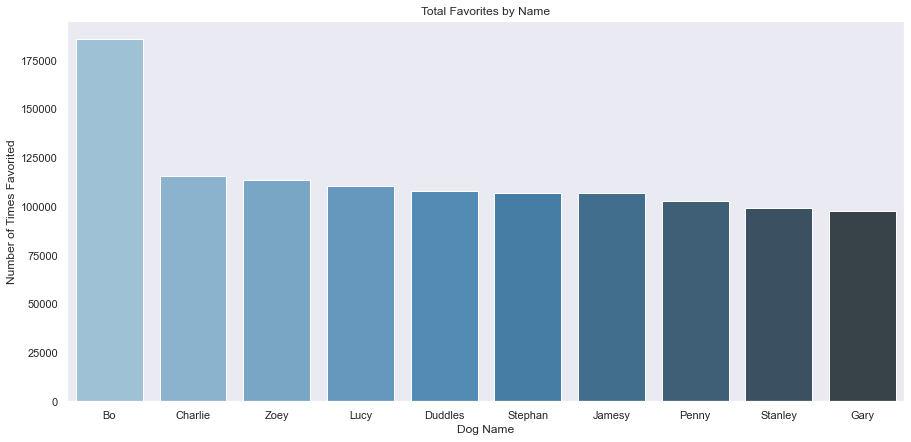

In [95]:
print(df_name_total.sort_values(by = 'favorite_count', ascending = False).head())
fig, ax = plt.subplots(figsize = (15,7))
sns.set_theme(style='dark')
ax = sns.barplot(x='dog_name', y='favorite_count', data=df_name_total.sort_values('favorite_count', ascending = False).iloc[:10],palette="Blues_d")
ax.set(xlabel = "Dog Name", ylabel = "Number of Times Favorited", title = "Total Favorites by Name");

Bo is clearly on top, but several of the other dog have changed places on the list. This makes me wonder how many Bo's there are. This may give the name an unfair advantage over the other dog names. 

In [180]:
dogs = ['Bo', 'Charlie', 'Zoey', 'Lucy', 'Duddles', 'Stephan', 'Jamesy', 'Penny', 'Stanley', 'Gary']
numbers = {'name':[], 'number':[], 'likes':[], 'retweets':[]}
for name in dogs:
    number = str(master_clean[master_clean['dog_name'] == name].dog_name.count())
    likes = master_clean[master_clean['dog_name'] == name].favorite_count.sum()
    retweet = master_clean[master_clean['dog_name'] == name].retweet_count.sum()
    numbers['name'].append(name)
    numbers['number'].append(number)
    numbers['likes'].append(likes)
    numbers['retweets'].append(retweet)
numbers=pd.DataFrame.from_dict(numbers, orient = 'columns')
numbers

,name,number,likes,retweets
0,Bo,6,185922,73800
1,Charlie,11,115468,30850
2,Zoey,3,113581,32201
3,Lucy,10,110523,35313
4,Duddles,1,107956,45849
5,Stephan,1,107015,56625
6,Jamesy,1,106827,32883
7,Penny,9,102986,31734
8,Stanley,6,99345,24460
9,Gary,4,97759,29038


It seems like Bo may have a bit of an advantage, but not as much as Charlie and Lucy.

## Insight 2

Next I want to take a look at the different breeds of dogs with the highest retweet count and number of likes.

              dog_breed  retweet_count  favorite_count
136    golden retriever         464314         1594339
182  labrador retriever         359558         1104820
244            pembroke         280367          994755
77            chihuahua         220695          676441
276             samoyed         184922          542991


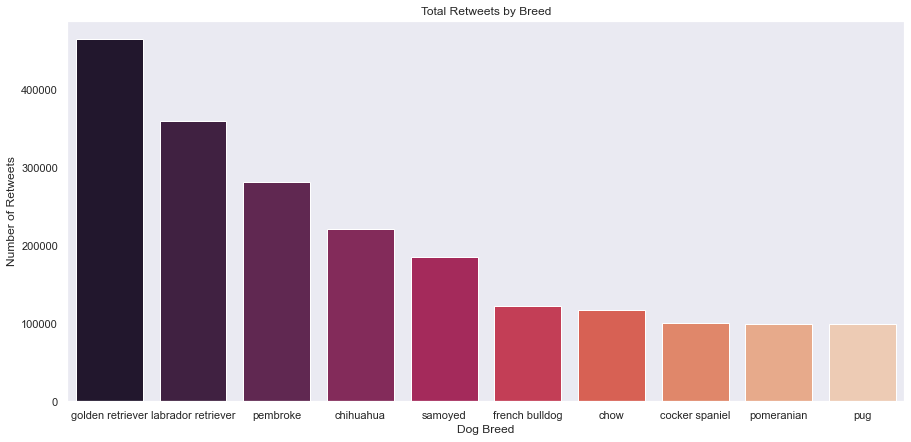

In [183]:
breed_counts_df = master_clean.groupby('dog_breed').agg({'retweet_count': 'sum', 'favorite_count': 'sum'}).reset_index()
print(breed_counts_df.sort_values(by = 'retweet_count', ascending = False).head())
fig, ax = plt.subplots(figsize = (15,7))
sns.set_theme(style='dark')
ax = sns.barplot(x='dog_breed', y='retweet_count', data=breed_counts_df.sort_values('retweet_count', ascending = False).iloc[:10],palette="rocket")
ax.set(xlabel = "Dog Breed", ylabel = "Number of Retweets", title = "Total Retweets by Breed");


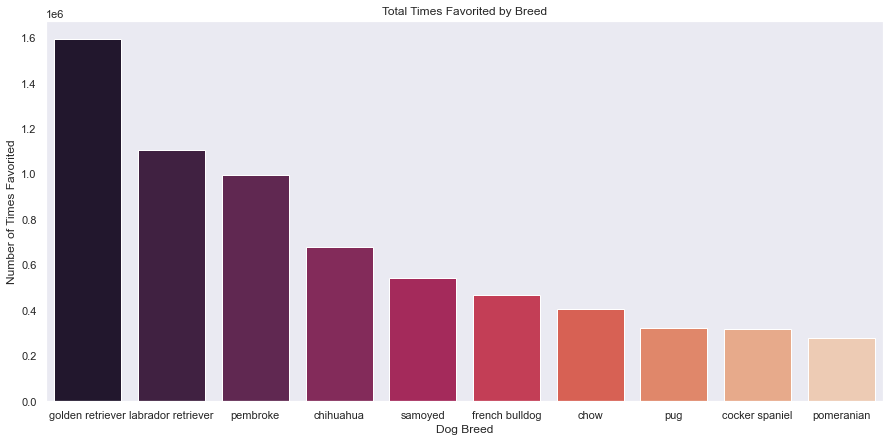

In [185]:
fig, ax = plt.subplots(figsize = (15,7))
sns.set_theme(style='dark')
ax = sns.barplot(x='dog_breed', y='favorite_count', data=breed_counts_df.sort_values('favorite_count', ascending = False).iloc[:10],palette="rocket")
ax.set(xlabel = "Dog Breed", ylabel = "Number of Times Favorited", title = "Total Times Favorited by Breed");

Golden retrievers are the clear winner of retweets and favorites. Prehaps because they are such photogenic dogs. Only the cocker spaniel, pug, and pomeranian changed positions. However, they are pretty close in both aspects.

In [176]:
columns = []
df_stage_total = master_clean[['stage', 'retweet_count', 'favorite_count', 'dog']].copy()
df_stage_total = df_stage_total[df_stage_total['dog'] == True][df_stage_total['stage'] !='unknown']
df_stage_total.head()


/var/folders/jm/2wbc1f696v97qw1_19ql23g00000gn/T/ipykernel_25137/4209030107.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_stage_total = df_stage_total[df_stage_total['dog'] == True][df_stage_total['stage'] !='unknown']


,stage,retweet_count,favorite_count,dog
9,doggo,7711,32467,True
12,puppo,8538,38818,True
14,puppo,2321,15359,True
28,pupper,3316,21524,True
37,doggo,3128,20771,True


In [194]:
total_favorite = df_stage_total['favorite_count'].sum()
stage_counts_df = df_stage_total.groupby('stage').agg({'favorite_count': 'sum'}).reset_index()
stage_counts_df['percentage'] = stage_counts_df['favorite_count'] / total_favorite
stage_counts_df

,stage,favorite_count,percentage
0,doggo,986705,0.371688
1,floofer,92442,0.034823
2,pupper,1151654,0.433824
3,puppo,423856,0.159665
4,unknown,0,0.000000


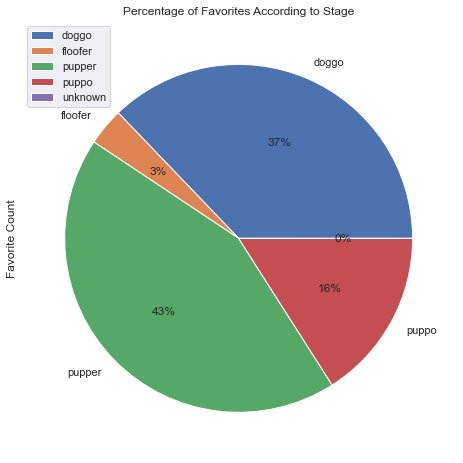

In [205]:
stage_counts_df.groupby(['stage']).sum().plot(
    kind='pie', y='favorite_count', figsize=(8, 8), autopct='%1.0f%%', ylabel = 'Favorite Count', title = 'Percentage of Favorites According to Stage');
#plot = stage_counts_df.plot.pie(y='percentage', figsize=(5, 8))

Out of all the identified stages pupper is the most liked with 43%.  

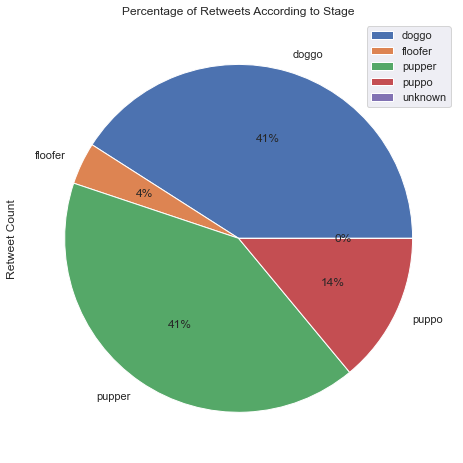

In [212]:
#colors =['blue', 'grey', 'red', 'purple']
df_stage_total.groupby(['stage']).sum().plot(
    kind='pie', y='retweet_count', figsize=(8, 8), autopct='%1.0f%%', ylabel = 'Retweet Count', title = 'Percentage of Retweets According to Stage');

The numbers for both pie charts are similar. Puppo and doggo are clearly retweeted and favorited more often. 

I would like to figure out how to make this visualization work. The issue is with the x axis. For some the values need to be represented like they are on the y axis, but I am not sure how to make that happen. Any advice would be appreciated. Hopefully, this will not keep me from passing as I have included other visualizations. 

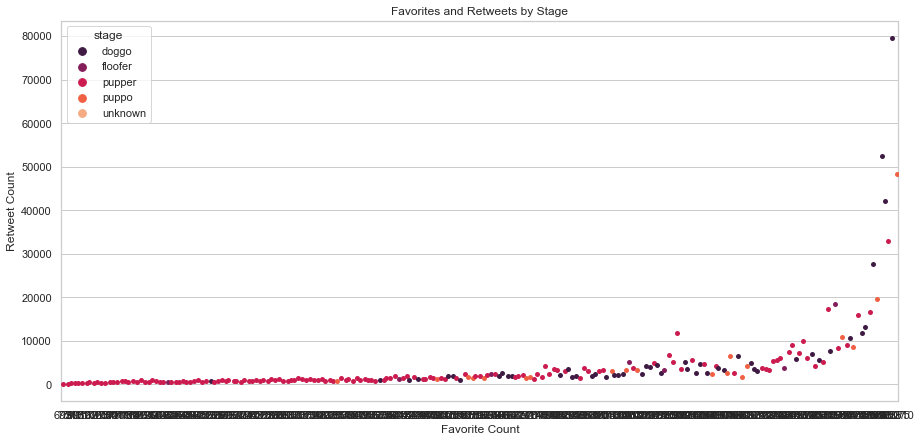

In [181]:
fig, ax = plt.subplots(figsize = (15,7))
ax = sns.stripplot(y="retweet_count", x='favorite_count', hue="stage", data=df_stage_total, palette="rocket", jitter=.25)
ax.set(ylabel = "Retweet Count", xlabel = "Favorite Count", title = "Favorites and Retweets by Stage");

#### [Return to top](#sixth-bullet)